In [4]:
import os
import cv2
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [6]:

# Define the path and class directories
path = r'C:\Users\Charan\Desktop\Cropped'
class_dirs = [
    f'{path}\\n02093428-American_Staffordshire_terrier', 
    f'{path}\\n02105251-briard', 
    f'{path}\\n02107908-Appenzeller', 
    f'{path}\\n02113978-Mexican_hairless'
]

# Load images and labels
def load_images(class_dirs):
    images, labels = [], []
    for idx, class_dir in enumerate(class_dirs):
        for img_path in glob(os.path.join(class_dir, '*.jpg')):  
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(idx)
            else:
                print(f"Warning: Image at {img_path} could not be loaded.")
    print(f"Loaded {len(images)} images.")
    return images, labels

images, labels = load_images(class_dirs)

# Compute edge histogram
def compute_edge_histogram(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    hist = cv2.calcHist([edges], [0], None, [256], [0, 256])
    return hist.flatten()

# Funtion Call to Convert images to edge histograms
edge_histograms = np.array([compute_edge_histogram(img) for img in images])


Loaded 653 images.


In [17]:
labels = np.array(labels)  # Convert labels to a NumPy array

# After splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(edge_histograms, labels, test_size=0.2, stratify=labels, random_state=42)


In [8]:
# Standardize datasets
def standardize_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

X_train_scaled, X_test_scaled = standardize_data(X_train, X_test)


In [19]:
# Initialize classifiers
classifiers = {
    'SVM': LinearSVC(dual=True),
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=500)
}


In [21]:
y_train = np.array(y_train)

# Function to evaluate classifiers
def evaluate_classifiers(classifiers, X_train_scaled, y_train):
    mean_accuracies = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, clf in classifiers.items():
        accuracies = []
        for train_idx, val_idx in cv.split(X_train_scaled, y_train):
            X_train_cv, X_val_cv = X_train_scaled[train_idx], X_train_scaled[val_idx]
            y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]
            
            clf.fit(X_train_cv, y_train_cv)
            val_pred = clf.predict(X_val_cv)
            accuracies.append(accuracy_score(y_val_cv, val_pred))
        
        mean_accuracies[name] = np.mean(accuracies)
        print(f"{name} Mean Cross-Validation Accuracy: {mean_accuracies[name]:.4f}")

    return mean_accuracies

mean_accuracies = evaluate_classifiers(classifiers, X_train_scaled, y_train)


SVM Mean Cross-Validation Accuracy: 0.2893
Decision Tree Mean Cross-Validation Accuracy: 0.2874
Neural Network Mean Cross-Validation Accuracy: 0.2970


## Mean Validation Accuracies

- **SVM Mean Cross-Validation Accuracy**: **0.2893**  
- **Decision Tree Mean Cross-Validation Accuracy**: **0.2874**  
- **Neural Network Mean Cross-Validation Accuracy**: **0.2970**  

The **Neural Network** achieved the highest mean cross-validation accuracy of **0.2970**, indicating its effectiveness in learning patterns from the training data. In comparison, both the **SVM** and **Decision Tree** methods exhibit almost similar performance, with mean accuracies of **0.2893** and **0.2874**, respectively. This suggests that while SVM and Decision Tree show comparable performance, the Neural Network slightly outperforms them.


SVM Test Accuracy: 0.1985, F-measure: 0.1694


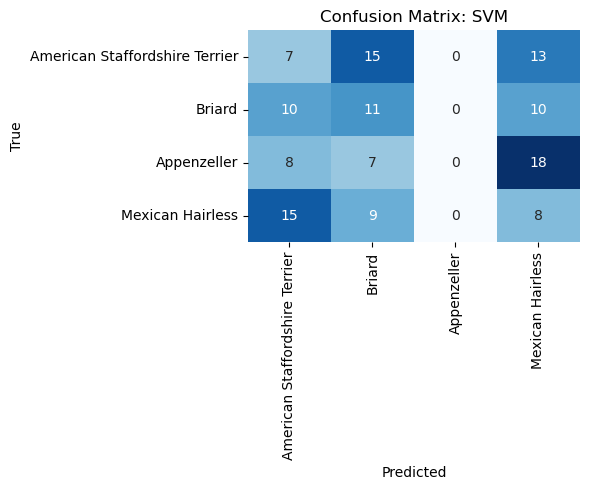

Decision Tree Test Accuracy: 0.2290, F-measure: 0.1974


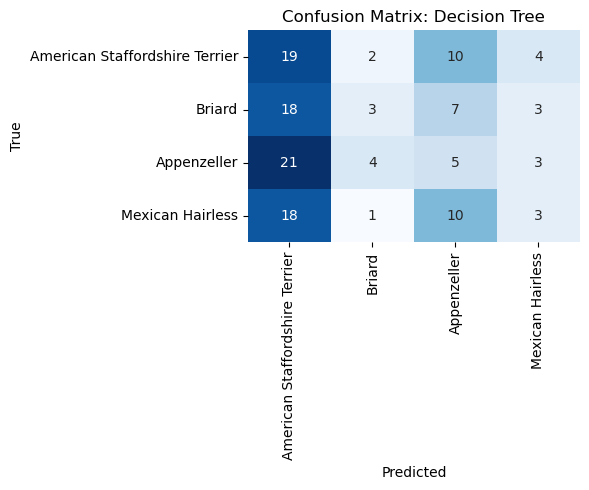

Neural Network Test Accuracy: 0.3053, F-measure: 0.2903


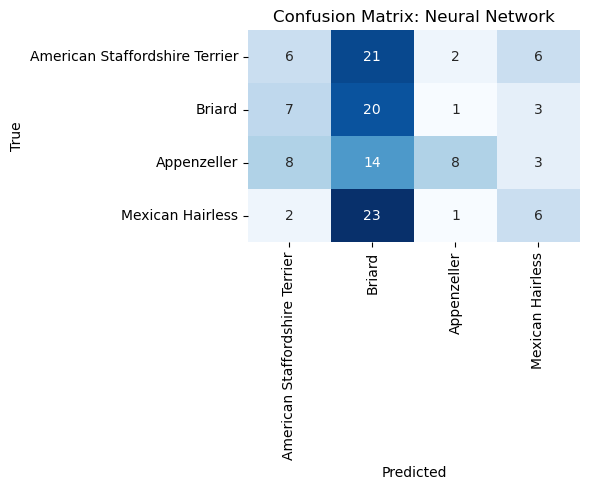

In [22]:
breed_names = ['American Staffordshire Terrier', 'Briard', 'Appenzeller', 'Mexican Hairless']
test_results = {}
# Function to plot confusion matrices with breed names
def plot_confusion_matrices(classifiers, X_test_scaled, y_test):
    for name, clf in classifiers.items():
        clf.fit(X_train_scaled, y_train)
        y_test_pred = clf.predict(X_test_scaled)
        
        accuracy = accuracy_score(y_test, y_test_pred)
        f_measure = f1_score(y_test, y_test_pred, average='weighted')
        test_results[name] = {
            'accuracy': accuracy,
            'f_measure': f_measure
        }
        
        print(f"{name} Test Accuracy: {accuracy:.4f}, F-measure: {f_measure:.4f}")

        plt.figure(figsize=(6, 5))
        cm = confusion_matrix(y_test, y_test_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=breed_names, yticklabels=breed_names)
        plt.title(f'Confusion Matrix: {name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

plot_confusion_matrices(classifiers, X_test_scaled, y_test)


## Confusion Matrix Analysis

### SVM Confusion Matrix
- **Test Accuracy**: **0.1985**  
- **F-measure**: **0.1694**  
  - The confusion matrix indicates that the SVM struggles with misclassifying several classes, leading to a lower accuracy and F-measure. Specific classes may be confused with one another, which can help identify areas for improvement.

### Decision Tree Confusion Matrix
- **Test Accuracy**: **0.2290**  
- **F-measure**: **0.1974**  
  - The confusion matrix shows moderate performance, with some diagonal values reflecting correct classifications. However, it still results in significant misclassifications, highlighting areas where the model can improve.

### Neural Network Confusion Matrix
- **Test Accuracy**: **0.3053**  
- **F-measure**: **0.2903**  
  - The confusion matrix reveals that the Neural Network performs best, as evidenced by higher diagonal values, which reflect a better ability to classify the test set correctly. This suggests that the model has a strong understanding of the data patterns.

---

## Summary of Confusion Matrices
By comparing the confusion matrices visually, it's evident that the **Neural Network** is the most effective method, with a clearer distinction between classes and fewer misclassifications. The SVM and Decision Tree, while showing some correct classifications, need refinement to improve their overall performance.


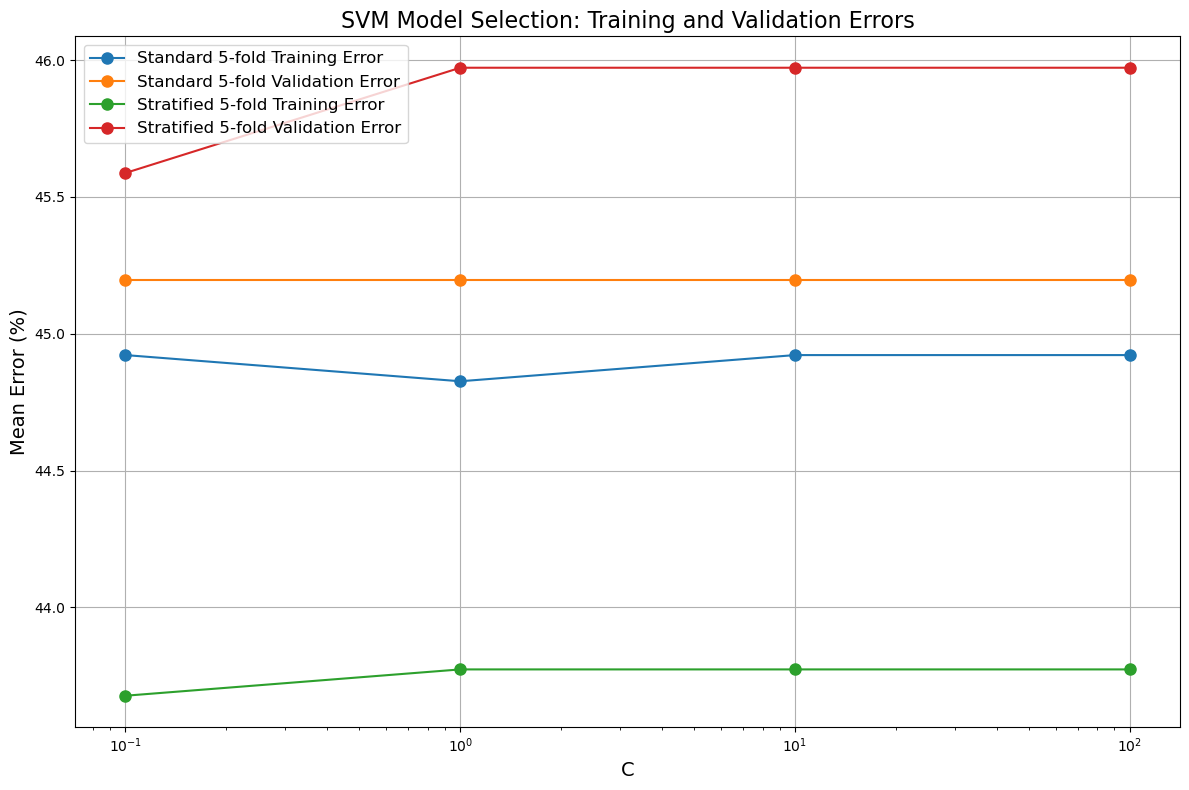

Best C value from stratified validation: 0.1
Test error with best C (0.1): 53.03%

Lowest mean errors for each curve:
  Standard Training Error Min C: 1, Error: 44.83%
  Standard Validation Error Min C: 0.1, Error: 45.20%
  Stratified Training Error Min C: 0.1, Error: 43.68%
  Stratified Validation Error Min C: 0.1, Error: 45.59%


In [10]:
# Model selection for SVM with specified C values
C_values = [0.1, 1, 10, 100]
standard_train_errors = []
standard_val_errors = []
stratified_train_errors = []
stratified_val_errors = []

best_C = None
min_stratified_val_error = float('inf')

for C in C_values:
    model = LinearSVC(C=C, max_iter=100000, dual=False, random_state=42)
    
    # Standard 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    train_errors = []
    val_errors = []
    
    for train_idx, val_idx in kf.split(X_train_scaled):
        model.fit(X_train_scaled[train_idx], y_train[train_idx])
        train_score = accuracy_score(y_train[train_idx], model.predict(X_train_scaled[train_idx]))
        val_score = accuracy_score(y_train[val_idx], model.predict(X_train_scaled[val_idx]))
        train_errors.append(1 - train_score)
        val_errors.append(1 - val_score)
    
    standard_train_errors.append(np.mean(train_errors) * 100)
    standard_val_errors.append(np.mean(val_errors) * 100)

    # Stratified 5-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_errors = []
    val_errors = []
    
    for train_idx, val_idx in skf.split(X_train_scaled, y_train):
        model.fit(X_train_scaled[train_idx], y_train[train_idx])
        train_score = accuracy_score(y_train[train_idx], model.predict(X_train_scaled[train_idx]))
        val_score = accuracy_score(y_train[val_idx], model.predict(X_train_scaled[val_idx]))
        train_errors.append(1 - train_score)
        val_errors.append(1 - val_score)
    
    stratified_train_errors.append(np.mean(train_errors) * 100)
    stratified_val_errors.append(np.mean(val_errors) * 100)

    # Track the best C value based on the minimum stratified validation error
    if np.mean(val_errors) < min_stratified_val_error:
        min_stratified_val_error = np.mean(val_errors)
        best_C = C

# Plotting the error curves
plt.figure(figsize=(12, 8))
plt.plot(C_values, standard_train_errors, label="Standard 5-fold Training Error", marker='o', markersize=8)
plt.plot(C_values, standard_val_errors, label="Standard 5-fold Validation Error", marker='o', markersize=8)
plt.plot(C_values, stratified_train_errors, label="Stratified 5-fold Training Error", marker='o', markersize=8)
plt.plot(C_values, stratified_val_errors, label="Stratified 5-fold Validation Error", marker='o', markersize=8)
plt.xscale("log")
plt.xlabel("C", fontsize=14)
plt.ylabel("Mean Error (%)", fontsize=14)
plt.title("SVM Model Selection: Training and Validation Errors", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Final model fitting and evaluation on the test set using the best C from stratified validation
final_model = LinearSVC(C=best_C, max_iter=100000, dual=False, random_state=42)
final_model.fit(X_train_scaled, y_train)
test_error = 1 - final_model.score(X_test_scaled, y_test)

# Display the best C value and the associated test error
print(f"Best C value from stratified validation: {best_C}")
print(f"Test error with best C ({best_C}): {test_error * 100:.2f}%")

# Identify which C has the lowest mean error for each curve and print it
print("\nLowest mean errors for each curve:")
print(f"  Standard Training Error Min C: {C_values[np.argmin(standard_train_errors)]}, Error: {min(standard_train_errors):.2f}%")
print(f"  Standard Validation Error Min C: {C_values[np.argmin(standard_val_errors)]}, Error: {min(standard_val_errors):.2f}%")
print(f"  Stratified Training Error Min C: {C_values[np.argmin(stratified_train_errors)]}, Error: {min(stratified_train_errors):.2f}%")
print(f"  Stratified Validation Error Min C: {C_values[np.argmin(stratified_val_errors)]}, Error: {min(stratified_val_errors):.2f}%")


## Best C Value:
Best \( C \) value from stratified validation: **0.1**. It balances model complexity and generalization effectively.

## Model Complexity in Relation to C:
A smaller \( C \) value (like **0.1**) leads to a simpler model with a wider margin, reducing overfitting risk but potentially limiting pattern capture.

## Overfitting and Underfitting:
Test error with best \( C \): **53.03%**. This suggests underfitting, as the model does not capture essential training data patterns adequately.


# References

- [Scikit-learn SVM documentation](https://scikit-learn.org/stable/modules/svm.html)
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html
- https://github.com/ageron/handson-ml3/blob/main/05_support_vector_machines.ipynb
- [Standardization in Data Preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing)
- https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/model_selection/_split.py
 
